# **GT4Py Tutorial : Stencil Basics**

## **Introduction**

This notebook will show how to create a simple GT4Py stencil that copies data from one variable to another.

### **Notebook Requirements**

- Python v3.11.x to v3.12.x
- [NOAA/NASA Domain Specific Language Middleware](https://github.com/NOAA-GFDL/NDSL)
- `ipykernel==6.1.0`
- [`ipython_genutils`](https://pypi.org/project/ipython_genutils/)

### **Quick GT4Py (Cartesian version) Overview**

GT4Py is a Domain Specific Language (DSL) in Python that enables a developer to write stencil computations.  Compared to simply running under Python, GT4Py achieves performance when the Python code is translated and compiled into a lower level language such as C++ and CUDA, which enables the codebase to execute on a multitude of architectures.  In this notebook, we will cover the basics of creating GT4Py stencils and demonstrate several intracies of the DSL. Additional information about GT4Py can be found at the [GT4Py site](https://gridtools.github.io/gt4py/latest/index.html).  One small note is that this tutorial covers and uses the Cartesian version of GT4Py and not the unstructured version.

### **GT4Py Parallel/Execution Model**

Within a 3-dimensional domain, GT4Py considers computations in two parts.  If we assume an `(I,J,K)` coordinate system as a reference, GT4Py separates computations in the Horizontal (`IJ`) spatial plane and Vertical (`K`) spatial interval.  In the Horizontal spatial plane, computations are implicitly executed in parallel, which also means that there is no assumed calculation order within the plane.  In the Vertical spatial interval, comptuations are specified by an iteration policy that will be discussed later through examples.

Another quick note is that the computations are executed sequentially in the order they appear in code.

## **Tutorial**

### **Copy Stencil example**

To demonstrate how to implement a GT4Py stencil, we'll step through an example that copies the values of one array into another array.  First, we import several packages. 

In [1]:
from gt4py.cartesian.gtscript import PARALLEL, computation, interval, stencil
from ndsl.dsl.typing import FloatField
from ndsl.quantity import Quantity
import numpy as np
from basic_boilerplate import plot_field_at_k0, plot_field_at_kN

2024-05-28 15:40:01|INFO|rank 0|ndsl.logging:Constant selected: ConstantVersions.GFS


As we walk through the example, we'll highlight different terms and such from the imported packages.  Let's first define, in GT4Py terms, two arrays of size 5 by 5 by 2 (dimensionally `I` by `J` by `K`).  These arrays are defined using a `Quantity` object, an NDSL data container for physical quantities.  More detailed information about the `Quantity` object and its arguments can be found from the [`Quantity` docstring](https://github.com/NOAA-GFDL/NDSL/blob/develop/ndsl/quantity.py#L270).  To make debugging easier, the `numpy` backend will be used.

In [2]:
backend = 'numpy'

nx = 5
ny = 5
nz = 2

shape = (nx, ny, nz)

qty_out = Quantity(data=np.zeros([nx, ny, nz]),
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

arr = np.indices(shape,dtype=float).sum(axis=0)  # Value of each entry is sum of the I and J index at each point

qty_in = Quantity(data=arr,
                  dims=["I", "J", "K"],
                  units="m",
                  gt4py_backend=backend)

We will next create a simple GT4Py stencil that copies values from one input to another.  A stencil will look like a Python subroutine or function except that it uses specific GT4Py functionalities.

In [3]:
@stencil(backend=backend)
def copy_stencil(input_field: FloatField,
                 output_field: FloatField):
    with computation(PARALLEL), interval(...):
        output_field = input_field

As mentioned before, GT4Py (cartesian version) was designed for stencil-based computation. Since stencil calculations generally are localized computations, GT4Py stencils are written using variables and the variable's relative location if it's an array.  If there are no indices in brackets next to a GT4Py type (such as `FloatField`), it's implied to be at the [0] (for 1-dimension), [0,0] (for 2-dimension), or [0,0,0] (for 3-dimension) location.  For the simple example `copy_stencil`, the value of `input_field` simply gets copied to `output_field` at every point in the domain of interest.

We see that this stencil does not contain any explicit loops.  As mentioned above in the notebook, GT4Py has a particular computation policy that implicitly executes in parallel within an `IJ` plane and is user defined in the `K` interval.  This execution policy in the `K` interval is dictated by the `computation` and `interval` keywords.  

- `with computation(PARALLEL)` means that there's no order preference to executing the `K` interval.  This also means that the `K` interval can be computed in parallel to potentially gain performace if computational resources are available.

- `interval(...)` means that the entire `K` interval is executed.  Instead of `(...)`, more specific intervals can be specified using a tuple of two integers.  For example... 

    - `interval(0,2)` : The interval `K` = 0 to 1 is executed.
    - `interval(0,-1)` : The interval `K` = 0 to N-2 (where N is the size of `K`) is executed.

The decorator `@stencil(backend=backend)` (Note: `stencil` comes from the package `gt4py.cartesian.gtscript`) converts `copy_stencil` to use the specified `backend` to "compile" the stencil.  `stencil` can also be a function call to create a stencil object.

In [4]:
copy_stencil_numpy = stencil(backend="numpy", definition=copy_stencil)

Note that the input and output parameters to `copy_stencil` are of type `FloatField`, which can essentially be thought of as a 3-dimensional NumPy array of `float` types.

`plot_field_at_kN` plots the values within the `IJ` plane at `K = 0` if no integer is specified or at `K` equal to the integer that is specified as an argument.  As we can see in the plots below, `copy_stencil` copies the values from `qty_in` into `qty_out`.

Plotting values of qty_in at K = 0
Min and max values: 8.0 0.0


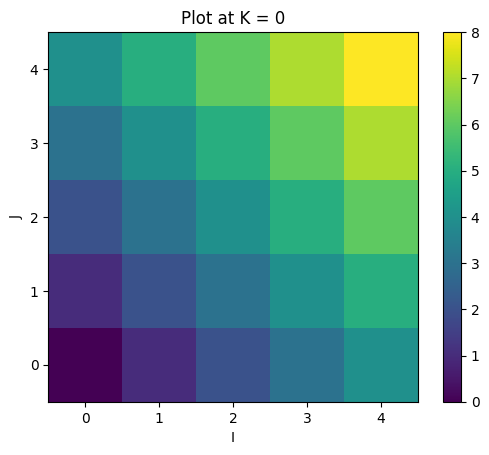

Plotting values of qty_out at K = 0
Min and max values: 0.0 0.0


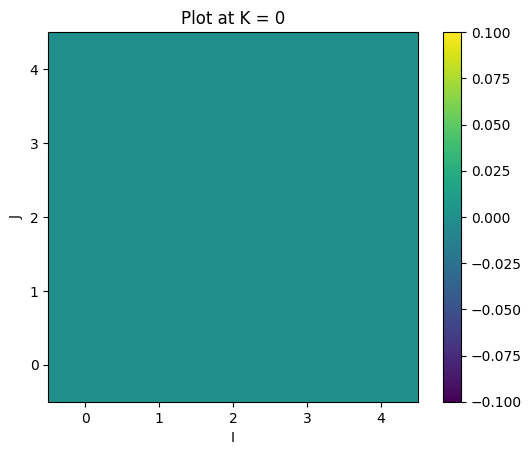

Executing `copy_stencil`
Plotting qty_out from `copy_stencil` at K = 0
Min and max values: 8.0 0.0


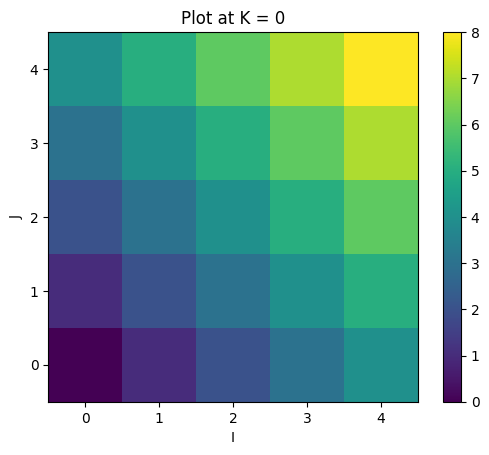

Plotting qty_out from `copy_stencil` at K = 1
Min and max values: 9.0 1.0


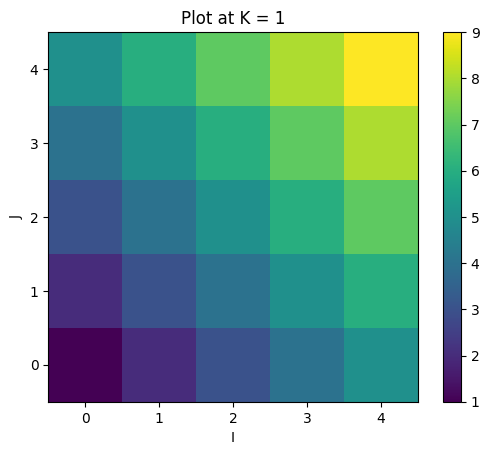

In [5]:
print("Plotting values of qty_in at K = 0")
plot_field_at_kN(qty_in.data)
print("Plotting values of qty_out at K = 0")
plot_field_at_kN(qty_out.data)
print("Executing `copy_stencil`")
copy_stencil(qty_in, qty_out)
print("Plotting qty_out from `copy_stencil` at K = 0")
plot_field_at_kN(qty_out.data)
print("Plotting qty_out from `copy_stencil` at K = 1")
plot_field_at_kN(qty_out.data,1)

### **Setting domain subsets in a stencil call**

GT4Py also allows a subset to be specified from a stencil call and executed in a fashion similar to using `interval(...)` in the K interval.  This is done by setting the stencil call's `origin` and `domain` argument.

- `origin` : This specifies the "starting" coordinate to perform computations.  

- `domain` : This specifies the range of the stencil computation based on `origin` as the "starting" coordinate (Note: May need to check whether this affects `interval()`)

If these two parameters are not set, the stencil call by default will iterate over the entire input domain.  The following demonstrates the effect of specifying different `origin` and `domain`.

Plotting values of qty_in at K = 0
Min and max values: 8.0 0.0


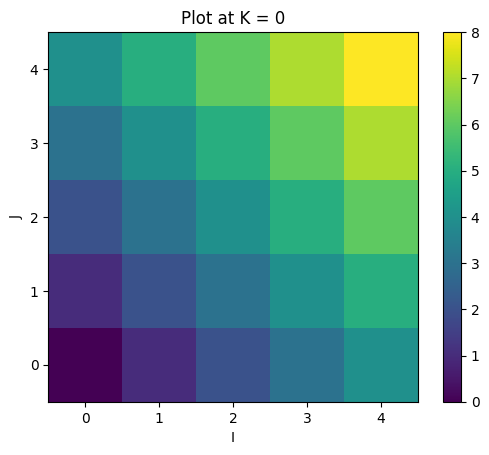

Plotting values of qty_out at K = 0
Min and max values: 0.0 0.0


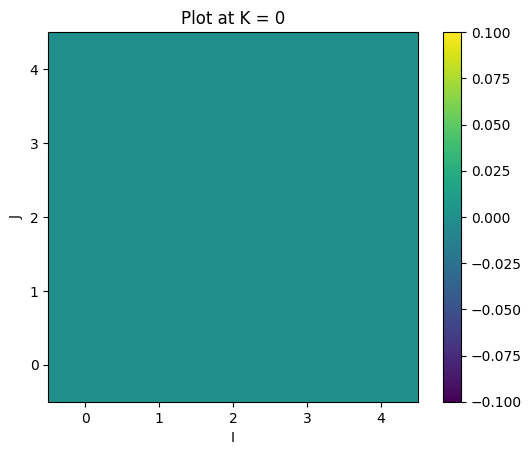

Executing `copy_stencil` with origin=(1,0,0)
Plotting qty_out at K = 0 based on `copy_stencil` with origin=(1,0,0)
Min and max values: 8.0 0.0


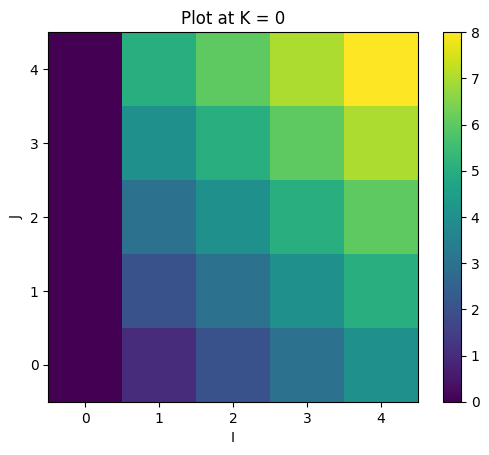

Resetting qty_out to zero...
Plotting values of qty_out at K = 0
Min and max values: 0.0 0.0


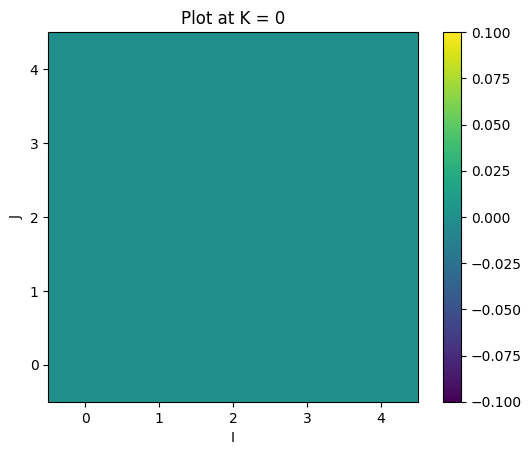

Executing `copy_stencil` with origin=(0,1,0)
Plotting qty_out at K = 0 based on `copy_stencil` with origin=(0,1,0)
Min and max values: 8.0 0.0


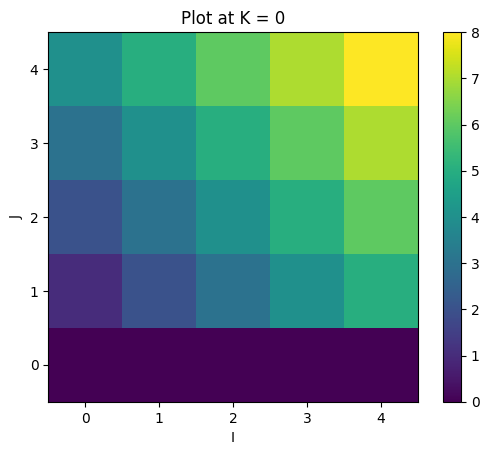

Resetting qty_out to zero...
Plotting values of qty_out at K = 0
Min and max values: 0.0 0.0


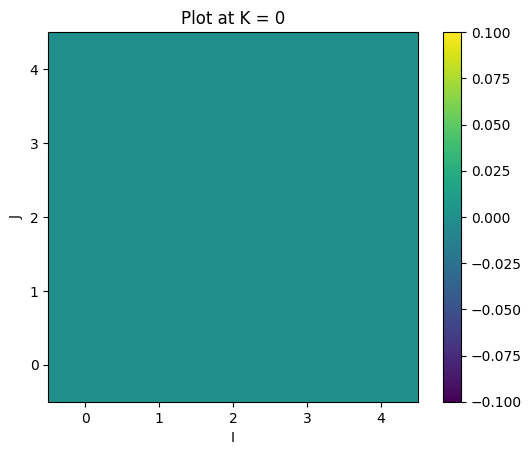

Executing `copy_stencil` with origin = (0,0,1)
Plotting qty_out at K = 0 based on `copy_stencil` with origin=(0,0,1)
Min and max values: 0.0 0.0


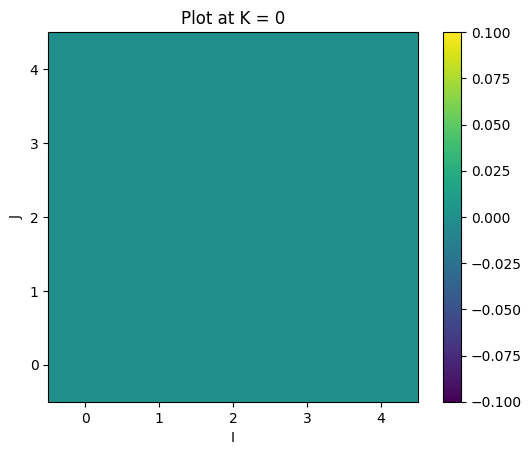

Plotting qty_out at K = 1 based on `copy_stencil` with origin=(0,0,1)
Min and max values: 9.0 1.0


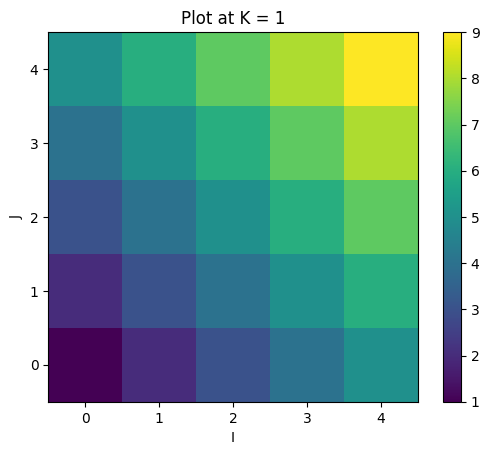

Resetting qty_out to zero...
Plotting values of qty_in at K = 0
Min and max values: 8.0 0.0


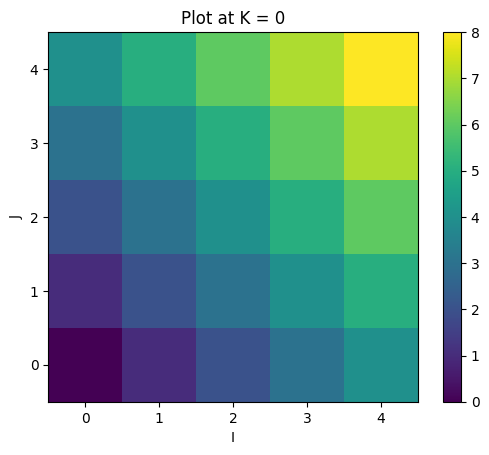

Plotting values of qty_out at K = 0
Min and max values: 0.0 0.0


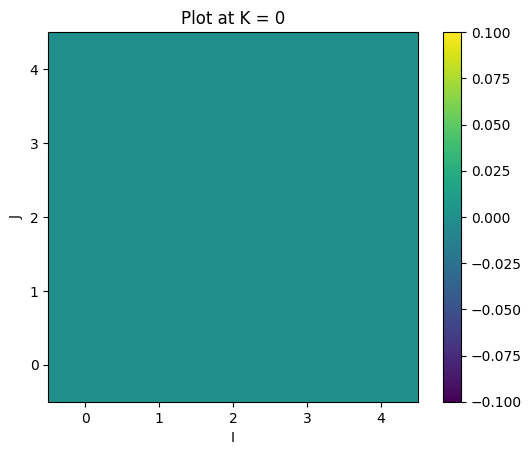

Executing `copy_stencil` with domain=(2,2,nz)
Plotting qty_out at K = 0 based on `copy_stencil` with domain = (2,2,nz)
Min and max values: 2.0 0.0


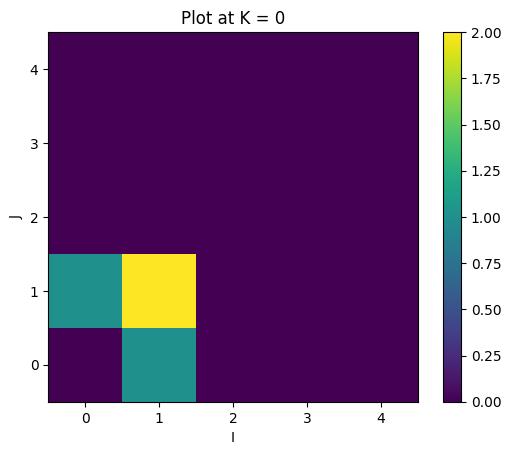

Resetting qty_out to zero...
Plotting values of qty_out at K = 0
Min and max values: 0.0 0.0


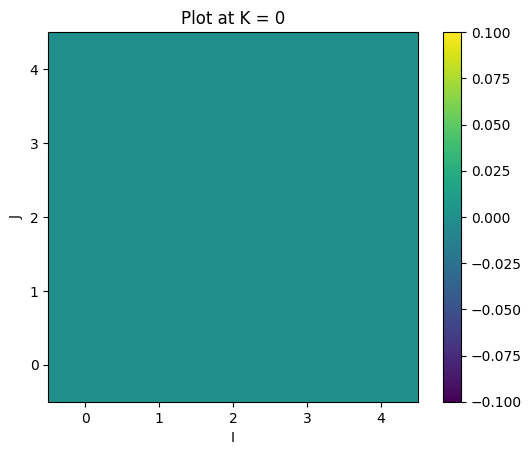

Executing `copy_stencil` with origin = (2,2,0), domain=(2,2,nz)
Plotting qty_out at K = 0 based on `copy_stencil` with origin = (2,2,0), domain = (2,2,nz)
Min and max values: 6.0 0.0


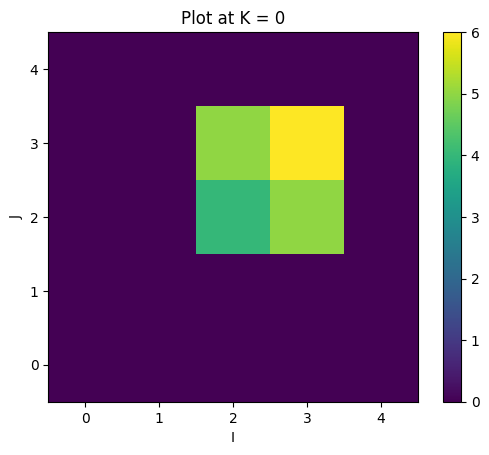

In [6]:
qty_out = Quantity(data=np.zeros([nx, ny, nz]),
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

print("Plotting values of qty_in at K = 0")
plot_field_at_kN(qty_in.data)
print("Plotting values of qty_out at K = 0")
plot_field_at_kN(qty_out.data)
print("Executing `copy_stencil` with origin=(1,0,0)")
copy_stencil(qty_in, qty_out,origin=(1,0,0))
print("Plotting qty_out at K = 0 based on `copy_stencil` with origin=(1,0,0)")
plot_field_at_kN(qty_out.data)

qty_out = Quantity(data=np.zeros([nx, ny, nz]),
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

print("Resetting qty_out to zero...")
print("Plotting values of qty_out at K = 0")
plot_field_at_kN(qty_out.data)
print("Executing `copy_stencil` with origin=(0,1,0)")
copy_stencil(qty_in, qty_out,origin=(0,1,0))
print("Plotting qty_out at K = 0 based on `copy_stencil` with origin=(0,1,0)")
plot_field_at_kN(qty_out.data)

qty_out = Quantity(data=np.zeros([nx, ny, nz]),
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

print("Resetting qty_out to zero...")
print("Plotting values of qty_out at K = 0")
plot_field_at_kN(qty_out.data)
print("Executing `copy_stencil` with origin = (0,0,1)")
copy_stencil(qty_in, qty_out,origin=(0,0,1))
print("Plotting qty_out at K = 0 based on `copy_stencil` with origin=(0,0,1)")
plot_field_at_kN(qty_out.data)
print("Plotting qty_out at K = 1 based on `copy_stencil` with origin=(0,0,1)")
plot_field_at_kN(qty_out.data, 1)

qty_out = Quantity(data=np.zeros([nx, ny, nz]),
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )
print("Resetting qty_out to zero...")
print("Plotting values of qty_in at K = 0")
plot_field_at_kN(qty_in.data)
print("Plotting values of qty_out at K = 0")
plot_field_at_kN(qty_out.data)
print("Executing `copy_stencil` with domain=(2,2,nz)")
copy_stencil(qty_in, qty_out, domain=(2,2,nz))
print("Plotting qty_out at K = 0 based on `copy_stencil` with domain = (2,2,nz)")
plot_field_at_kN(qty_out.data)

qty_out = Quantity(data=np.zeros([nx, ny, nz]),
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )
print("Resetting qty_out to zero...")
print("Plotting values of qty_out at K = 0")
plot_field_at_kN(qty_out.data)
print("Executing `copy_stencil` with origin = (2,2,0), domain=(2,2,nz)")
copy_stencil(qty_in, qty_out, origin=(2,2,0), domain=(2,2,nz))
print("Plotting qty_out at K = 0 based on `copy_stencil` with origin = (2,2,0), domain = (2,2,nz)")
plot_field_at_kN(qty_out.data)

### **`FORWARD` and `BACKWARD` `computation` keywords and Offset Indexing within a stencil call**

Besides `PARALLEL`, the developer can specify `FORWARD` or `BACKWARD` as the iteration policy in `K` for a stencil.  Essentially, the `FORWARD` policy has `K` iterating consecutively starting from the lowest vertical index to the highest, while the `BACKWARD` policy performs the reverse.

An array-based stencil variable can also have an integer dimensional offset if the array variable is on the right hand side of the `=` for the computation.  When a computation is performed at a particular point, an offset variable's coordinate is based on that particular point plus (or minus) the offset in the offset dimension.

The following examples demonstrate the use of these two iteration policies and also offset indexing in the `K` dimension.  Note that offsets can also be applied to the `I` or `J` dimension.

Plotting values of qty_in at K = 0
Min and max values: 12.0 0.0


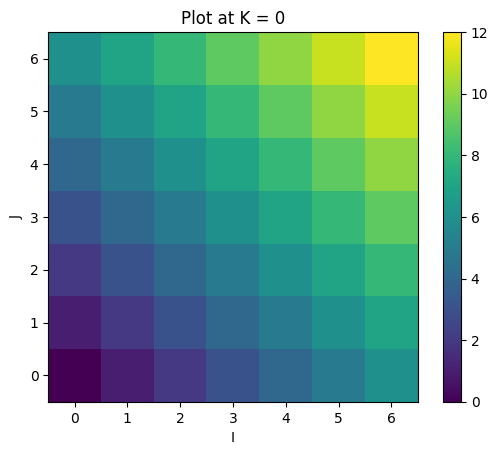

Plotting values of qty_in at K = 1
Min and max values: 13.0 1.0


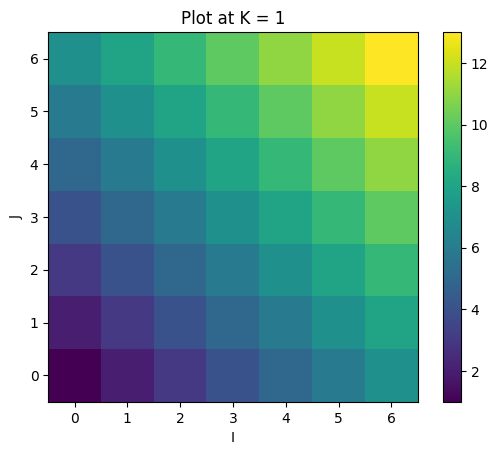

Plotting values of qty_in at K = 2
Min and max values: 14.0 2.0


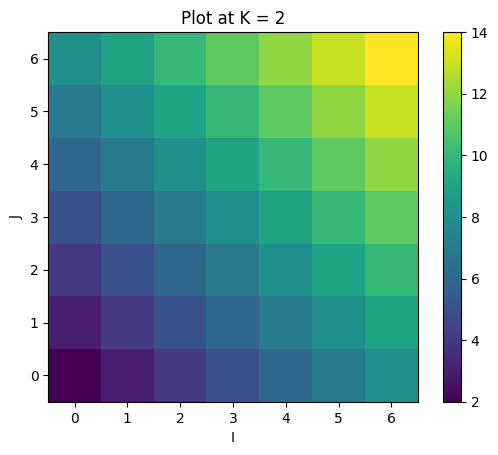

Executing 'mult_upward' with origin=(nhalo,nhalo,0),domain=(nx,ny,2)
Plotting values of qty_out at K = 0 with origin=(nhalo,nhalo,1),domain=(nx,ny,2)
Min and max values: 0.0 0.0


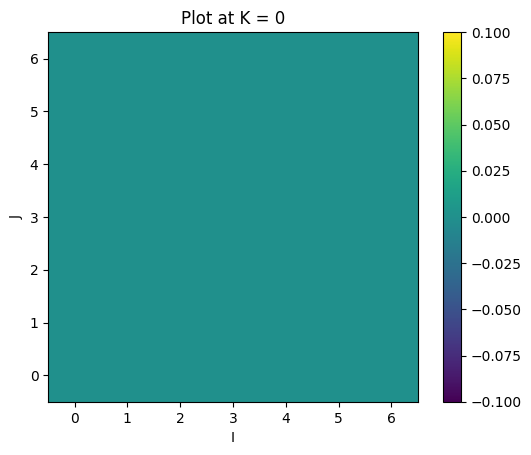

Plotting values of qty_out at K = 1 with origin=(nhalo,nhalo,1),domain=(nx,ny,2)
Min and max values: 20.0 0.0


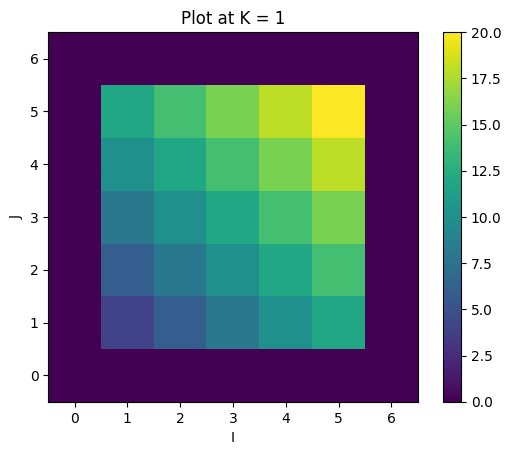

Plotting values of qty_out at K = 2 with origin=(nhalo,nhalo,1),domain=(nx,ny,2)
Min and max values: 22.0 0.0


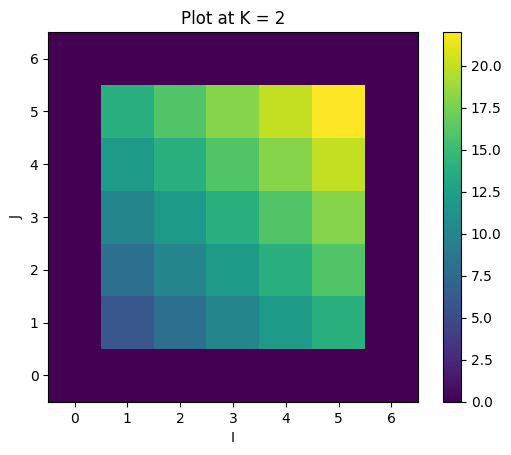

Plotting values of qty_out at K = 3 with origin=(nhalo,nhalo,1),domain=(nx,ny,2)
Min and max values: 0.0 0.0


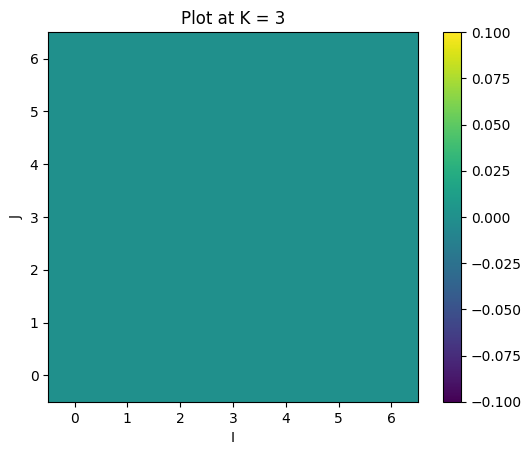

Resetting qty_out to zeros
Executing 'copy_downward' with origin=(1,1,0), domain=(nx,ny,nz-1)
***
Plotting values of qty_out at K = 0
Min and max values: 11.0 0.0


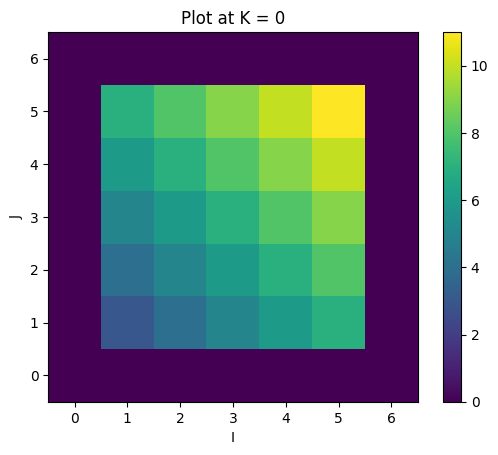

Plotting values of qty_out at K = 1
Min and max values: 12.0 0.0


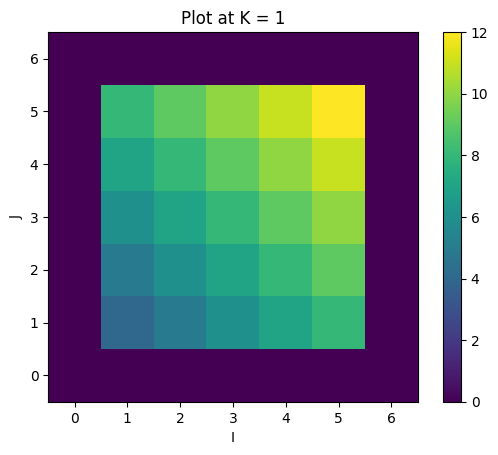

Plotting values of qty_out at K = 2
Min and max values: 13.0 0.0


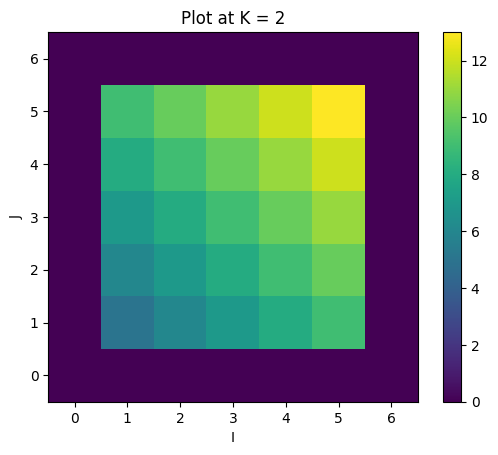

In [7]:
from gt4py.cartesian.gtscript import FORWARD, BACKWARD

nx = 5
ny = 5
nz = 5
nhalo = 1
backend="numpy"

shape = (nx + 2 * nhalo, ny + 2 * nhalo, nz)

qty_out = Quantity(data=np.zeros(shape),
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

arr = np.indices(shape,dtype=float).sum(axis=0)  # Value of each entry is sum of the I and J index at each point
qty_in = Quantity(data=arr,
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

print("Plotting values of qty_in at K = 0")
plot_field_at_kN(qty_in.data,0)
print("Plotting values of qty_in at K = 1")
plot_field_at_kN(qty_in.data,1)
print("Plotting values of qty_in at K = 2")
plot_field_at_kN(qty_in.data,2)

@stencil(backend=backend)
def mult_upward(qty_in: FloatField, qty_out: FloatField):
    with computation(FORWARD), interval(...):
        qty_out = qty_in[0,0,-1] * 2.0

print("Executing 'mult_upward' with origin=(nhalo,nhalo,0),domain=(nx,ny,2)")
mult_upward(qty_in, qty_out, origin=(nhalo,nhalo,1), domain=(nx,ny,2))
print("Plotting values of qty_out at K = 0 with origin=(nhalo,nhalo,1),domain=(nx,ny,2)")
plot_field_at_kN(qty_out.data,0)
print("Plotting values of qty_out at K = 1 with origin=(nhalo,nhalo,1),domain=(nx,ny,2)")
plot_field_at_kN(qty_out.data,1)
print("Plotting values of qty_out at K = 2 with origin=(nhalo,nhalo,1),domain=(nx,ny,2)")
plot_field_at_kN(qty_out.data,2)
print("Plotting values of qty_out at K = 3 with origin=(nhalo,nhalo,1),domain=(nx,ny,2)")
plot_field_at_kN(qty_out.data,3)

@stencil(backend=backend)
def copy_downward(qty_in: FloatField, qty_out: FloatField):
    with computation(BACKWARD), interval(...):
        qty_out = qty_in[0,0,1]

print("Resetting qty_out to zeros")
qty_out = Quantity(data=np.zeros(shape),
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

print("Executing 'copy_downward' with origin=(1,1,0), domain=(nx,ny,nz-1)")
copy_downward(qty_in, qty_out, origin=(1,1,0), domain=(nx,ny,nz-1))
print("***")
print("Plotting values of qty_out at K = 0")
plot_field_at_kN(qty_out.data,0)
print("Plotting values of qty_out at K = 1")
plot_field_at_kN(qty_out.data,1)
print("Plotting values of qty_out at K = 2")
plot_field_at_kN(qty_out.data,2)

Regarding offsets, GT4Py does not allow offsets to variables in the left hand side of the `=`.  Uncomment and execute the below code to see the error `Assignment to non-zero offsets is not supported.`.

In [8]:
# @stencil(backend=backend)
# def mult_upward_error(qty_in: FloatField, qty_out: FloatField):
#     with computation(FORWARD), interval(...):
#         qty_out[0,-1,-1] = qty_in * 2.0

### **Limits to offset : Cannot set offset outside of usable domain**

Note that there are limits to the offsets that can be applied in the stencil.  An error will result if the specified shift results attemps to read data that is not available or allocated.  In the example below, a shift of -2 in the `J` axis will shift `field_in` out of its possible range in `J`.

Executing 'copy_stencil' with origin=(nhalo, nhalo,0), domain=(nx, ny, nz)
Executing 'copy_stencil' where qty_out is copied back to qty_in
Min and max values: 10.0 0.0


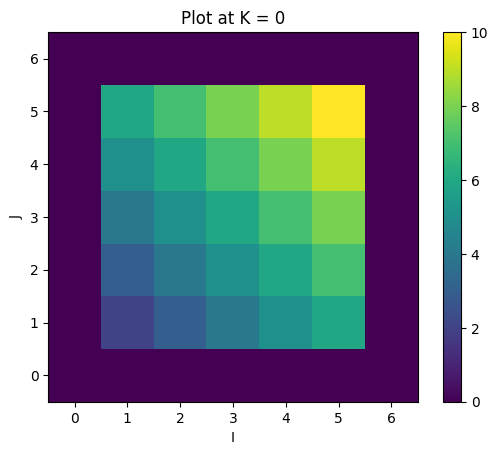

Executing 'copy_stencil_offset' where origin=(nhalo, nhalo,0), domain=(nx, ny, nz)


ValueError: Origin for field field_in too small. Must be at least (0, 2, 0), is (1, 1, 0)

In [12]:
nx = 5
ny = 5
nz = 5
nhalo = 1
backend="numpy"

shape = (nx + 2 * nhalo, ny + 2 * nhalo, nz)

qty_out = Quantity(data=np.zeros(shape),
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

arr = np.indices(shape,dtype=float).sum(axis=0)  # Value of each entry is sum of the I and J index at each point
qty_in = Quantity(data=arr,
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

@stencil(backend=backend)
def copy_stencil_offset(field_in: FloatField, field_out: FloatField):
    with computation(PARALLEL), interval(...):
        field_out = field_in[0,-2,0]

print("Executing 'copy_stencil' with origin=(nhalo, nhalo,0), domain=(nx, ny, nz)")
copy_stencil(qty_in, qty_out, origin=(nhalo, nhalo,0), domain=(nx, ny, nz))
print("Executing 'copy_stencil' where qty_out is copied back to qty_in")
copy_stencil(qty_out, qty_in)
plot_field_at_kN(qty_in.data,0)
print("Executing 'copy_stencil_offset' where origin=(nhalo, nhalo,0), domain=(nx, ny, nz)")
copy_stencil_offset(qty_in, qty_out, origin=(nhalo, nhalo,0), domain=(nx, ny, nz))
plot_field_at_kN(qty_out.data,0)

### **`if/else` statements**

GT4Py allows for `if/else` statements to exist within a stencil.  The following simple example shows a stencil `stencil_if_zero` modifing values of `in_out_field` depending on its initial value.

Plotting values of qty_in at K = 0
Min and max values: 12.0 0.0


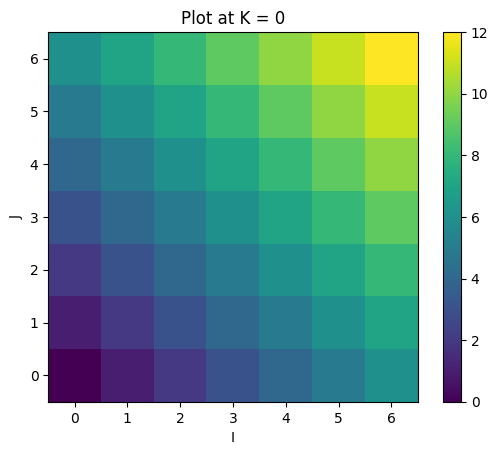

Plotting values of qty_out at K = 0
Min and max values: 0.0 0.0


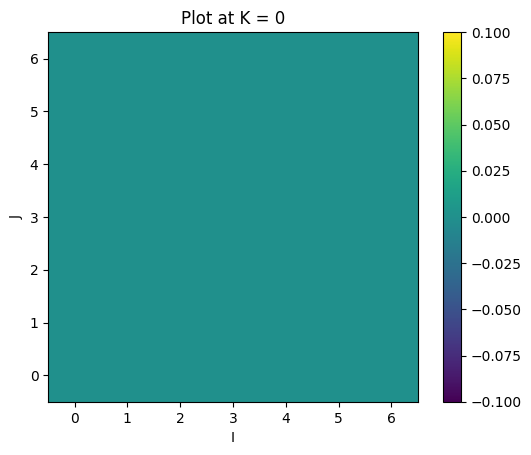

Running copy_stencil with origin=(nhalo,nhalo,0),domain=(nx,ny,5)
Plotting values of qty_out at K = 0 based on running copy_stencil with origin=(nhalo,nhalo,0),domain=(nx,ny,5)
Min and max values: 10.0 0.0


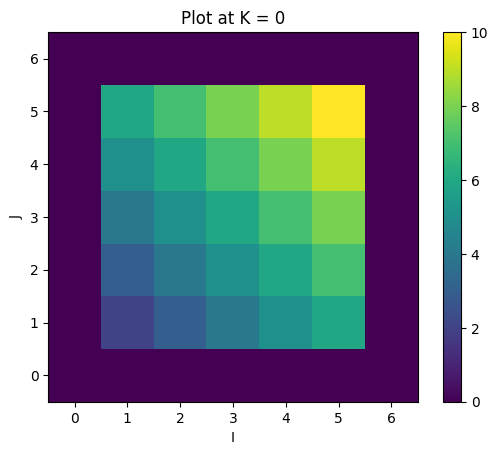

Plotting values of qty_out at K = 1 based on running copy_stencil with origin=(nhalo,nhalo,0),domain=(nx,ny,5)
Min and max values: 11.0 0.0


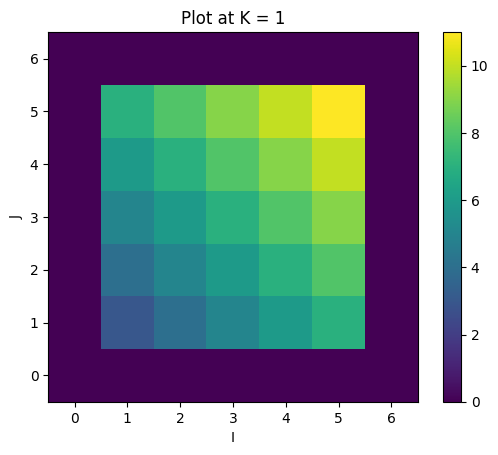

Running 'stencil_if_zero' on qty_out
Plotting values of qty_out at K = 0 based on running stencil_if_zero
Min and max values: 30.0 10.0


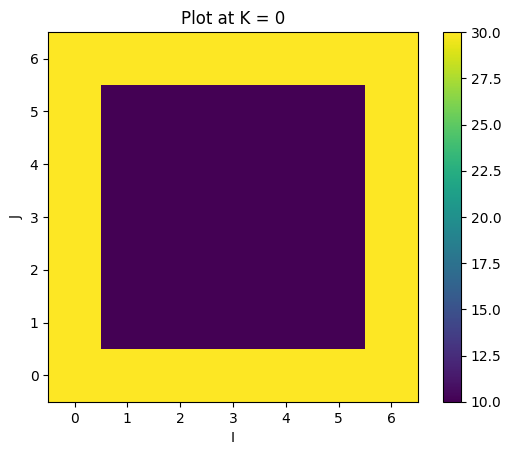

Plotting values of qty_out at K = 1 based on running stencil_if_zero
Min and max values: 30.0 10.0


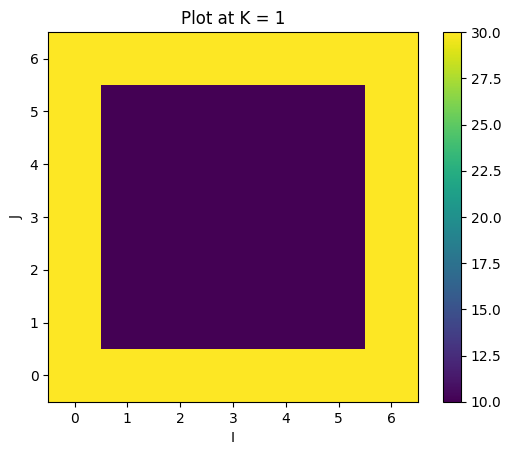

In [10]:
qty_out = Quantity(data=np.zeros(shape),
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

arr = np.indices(shape,dtype=float).sum(axis=0)  # Value of each entry is sum of the I and J index at each point
qty_in = Quantity(data=arr,
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

print("Plotting values of qty_in at K = 0")
plot_field_at_kN(qty_in.data,0)
print("Plotting values of qty_out at K = 0")
plot_field_at_kN(qty_out.data,0)
print("Running copy_stencil with origin=(nhalo,nhalo,0),domain=(nx,ny,5)")
copy_stencil(qty_in,qty_out,origin=(nhalo,nhalo,0),domain=(nx,ny,5))
print("Plotting values of qty_out at K = 0 based on running copy_stencil with origin=(nhalo,nhalo,0),domain=(nx,ny,5)")
plot_field_at_kN(qty_out.data,0)
print("Plotting values of qty_out at K = 1 based on running copy_stencil with origin=(nhalo,nhalo,0),domain=(nx,ny,5)")
plot_field_at_kN(qty_out.data,1)

@stencil(backend=backend)
def stencil_if_zero(in_out_field: FloatField):
    with computation(PARALLEL), interval(...):
        if in_out_field == 0.0:
            in_out_field = 30
        else:
            in_out_field = 10
print("Running 'stencil_if_zero' on qty_out")
stencil_if_zero(qty_out)
print("Plotting values of qty_out at K = 0 based on running stencil_if_zero")
plot_field_at_kN(qty_out.data,0)
print("Plotting values of qty_out at K = 1 based on running stencil_if_zero")
plot_field_at_kN(qty_out.data,1)

### **Function calls**

GT4Py also has the capability to create functions in order to better organize code.  The main difference between a GT4Py function call and a GT4Py stencil is that a function does not (and cannot) contain the keywords `computation` and `interval`.  However, array index referencing within a GT4py function is the same as in a GT4Py stencil.

GT4Py functions can be created by using the decorator `function` (Note: `function` originates from the package `gt4py.cartesian.gtscript`).

Plotting values of qty_in at K = 0
Min and max values: 12.0 0.0


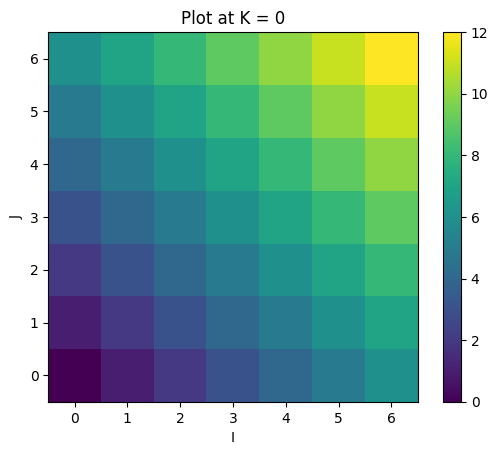

Plotting values of qty_out at K = 0
Min and max values: 0.0 0.0


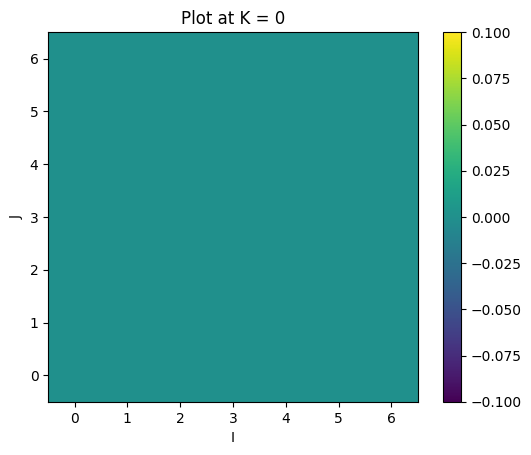

Executing 'field_plus_one'
Plotting values of qty_out at K = 0 after executing 'field_plus_one'
Min and max values: 13.0 1.0


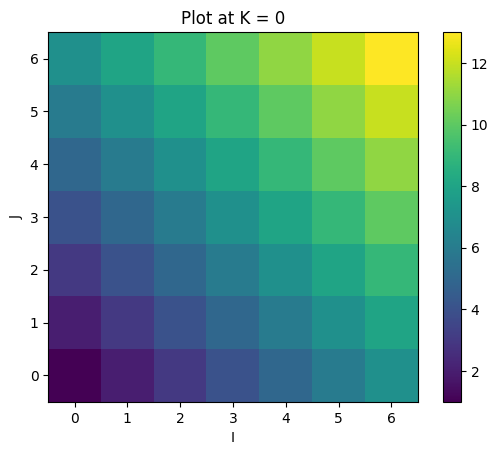

In [11]:
from gt4py.cartesian.gtscript import function

@function
def plus_one(field: FloatField):
   return field[0, 0, 0] + 1

@stencil(backend=backend)
def field_plus_one(source: FloatField, target: FloatField):
   with computation(PARALLEL), interval(...):
       target = plus_one(source)

nx = 5
ny = 5
nz = 5
nhalo = 1
backend="numpy"

shape = (nx + 2 * nhalo, ny + 2 * nhalo, nz)

qty_out = Quantity(data=np.zeros(shape),
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

arr = np.indices(shape, dtype=float).sum(axis=0)  # Value of each entry is sum of the I and J index at each point
qty_in = Quantity(data=arr,
                   dims=["I", "J", "K"],
                   units="m",
                   gt4py_backend=backend
                   )

print("Plotting values of qty_in at K = 0")
plot_field_at_kN(qty_in.data)
print("Plotting values of qty_out at K = 0")
plot_field_at_kN(qty_out.data)
print("Executing 'field_plus_one'")
field_plus_one(qty_in, qty_out)
print("Plotting values of qty_out at K = 0 after executing 'field_plus_one'")
plot_field_at_kN(qty_out.data)